# **Model Training for Problem 2**

In this file, after performing the preprocessing steps described in the file *PPQ2* and preparing the data, the focus has been on training various models and identifying the best one for **Problem 2**.

**Problem 2**: Suppose we need to predict the number of passengers in different time periods one week in advance, in order to allocate a suitable number of trains.

In the end, the best models have been identified based on the evaluation metrics **RMSE** and **R²**.


 **Training Process and Model Selection**

The overall workflow was as follows: for each missing value imputation method, multiple models were trained and their results were saved.

A few important points:

1. Three imputation methods were used: **'-1 imputation'**, **'mean imputation'**, and **'KNN imputation'**.
2. Based on the results obtained from **Problem 1**, the following models were selected: **KNN**, **XGBoost**, **ANN**, **LSTM**, and **RNN**.
3. In total, **15 models** were trained and evaluated.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout,  Input, LSTM, Concatenate,  Masking, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint


In [3]:
rmse_results_minus1 = {}
r2_results_minus1 = {}
rmse_results_mean = {}
r2_results_mean = {}
rmse_results_knn = {}
r2_results_knn = {}

In [4]:
def sns_jointplot(y_pred, y_test):
  g = sns.jointplot(x=y_pred, y=y_test, kind='scatter')
  plt.xlabel('y_pred')
  plt.ylabel('y_label')
  if np.all(y_pred >= 0):
    g.ax_joint.set_xlim(0-1000, y_test.max()+1000)
  g.ax_joint.set_ylim(0-1000, y_test.max()+1000)
  plt.show()

# Models with -1 Imputation for Missing Lag Values 

In [68]:
X_train = pd.read_csv('data\Q2\\fill_mines1\X_train.csv')
X_val = pd.read_csv('data\Q2\\fill_mines1\X_val.csv')
X_test = pd.read_csv('data\Q2\\fill_mines1\X_test.csv')
y_train = pd.read_csv('data\Q2\\fill_mines1\y_train.csv').values.ravel()
y_val = pd.read_csv('data\Q2\\fill_mines1\y_val.csv').values.ravel()
y_test = pd.read_csv('data\Q2\\fill_mines1\y_test.csv').values.ravel()
y_test = np.round(np.expm1(y_test))

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(46516, 92) (8192, 92) (9658, 92)
(46516,) (8192,) (9658,)


In [69]:
X_train.columns

Index(['Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September',
       'Corridor_Corridor_1', 'Corridor_Corridor_2', 'Corridor_Corridor_3',
       'Corridor_Corridor_4', 'Corridor_Corridor_5', 'Corridor_Corridor_6',
       'Corridor_Corridor_7', 'Station_Station_1', 'Station_Station_10',
       'Station_Station_11', 'Station_Station_12', 'Station_Station_13',
       'Station_Station_14', 'Station_Station_15', 'Station_Station_16',
       'Station_Station_17', 'Station_Station_18', 'Station_Station_19',
       'Station_Station_2', 'Station_Station_20', 'Station_Station_21',
       'Station_Station_22', 'Station_Station_23', 'Station_Station_24',
       'Station_Station_25', 'Station_Station_26', 'Station_Station_27',
       'Station_Station_28', 'Station_Station_29', 'Station_Station_3',
       'Station_Station_30', 'Station_Station_31', 

In [70]:
X_train_notmiscol = X_train.drop(columns=['lag_7_missing', 'lag_8_missing', 'lag_9_missing', 'lag_14_missing',
       'lag_21_missing', 'lag_28_missing'], axis=1)
X_val_notmiscol = X_val.drop(columns=['lag_7_missing', 'lag_8_missing', 'lag_9_missing', 'lag_14_missing',
       'lag_21_missing', 'lag_28_missing'], axis=1)
X_test_notmiscol = X_test.drop(columns=['lag_7_missing', 'lag_8_missing', 'lag_9_missing', 'lag_14_missing',
       'lag_21_missing', 'lag_28_missing'], axis=1)


# Usage in sequential models and XGBoost

## KNN

In [9]:
model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': np.arange(70), 
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2],
    }
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])
train_indices = np.arange(len(X_train))
val_indices = np.arange(len(X_train), len(X_train) + len(X_val))
cv_split = [(train_indices, val_indices)]
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=4, verbose=3)
grid_search.fit(X_combined, y_combined)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

joblib.dump(best_model, 'models_Q2\KNN_minus1.joblib')

Fitting 1 folds for each of 280 candidates, totalling 280 fits
Best parameters: {'metric': 'minkowski', 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


['models_Q2\\KNN_minus1.joblib']

RMSE: 512.7598799147577
R^2: 0.8865188450058539


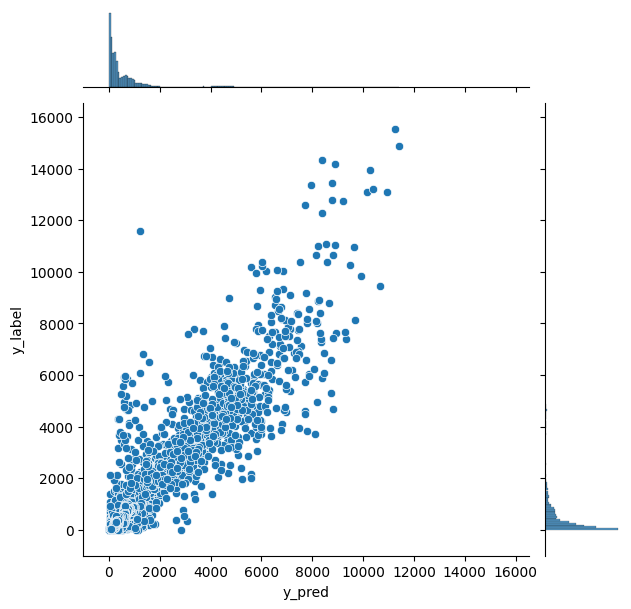

In [10]:
model_KNN = joblib.load('models_Q2\KNN_minus1.joblib')


y_pred = model_KNN.predict(X_test)
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_minus1['KNN'] = rmse
r2_results_minus1['KNN'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred, y_test)

## XGBoost

In [11]:
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', tree_method= 'gpu_hist', missing=-1)
param_grid = {
    'n_estimators': [200, 500, 700, 1000],
    'learning_rate': [0.001, 0.01, 0.02, 0.05, 0.1],
    'max_depth': [3, 6, 10, 13],
    'gamma': [0, 0.2]
    }
X_combined = np.concatenate([X_train_notmiscol, X_val_notmiscol])
y_combined = np.concatenate([y_train, y_val])
train_indices = np.arange(len(X_train_notmiscol))
val_indices = np.arange(len(X_train_notmiscol), len(X_train_notmiscol) + len(X_val_notmiscol))
cv_split = [(train_indices, val_indices)]
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=6)
grid_search.fit(X_combined, y_combined)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

joblib.dump(best_model, 'models_Q2\XGBoost_minus1.joblib')

Best parameters: {'gamma': 0.2, 'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 1000}


['models_Q2\\XGBoost_minus1.joblib']

RMSE: 480.86584195834814
R^2: 0.9001970152633918


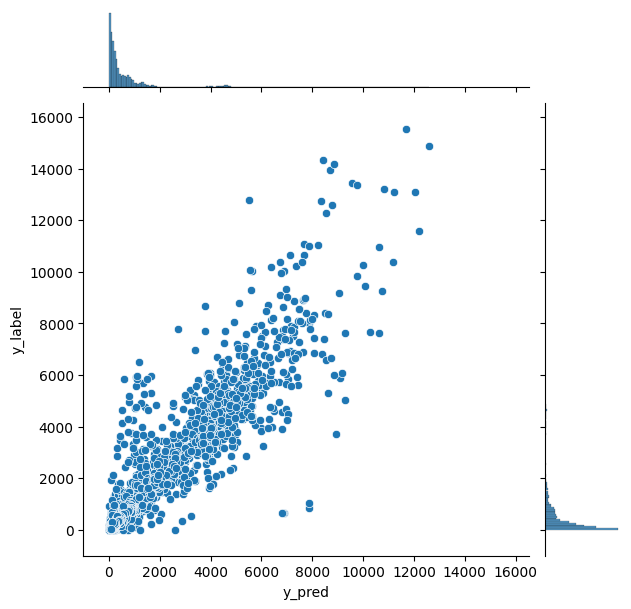

In [12]:
model_XGBoost = joblib.load('models_Q2\XGBoost_minus1.joblib')


y_pred = model_XGBoost.predict(X_test_notmiscol)
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_minus1['XGBoost'] = rmse
r2_results_minus1['XGBoost'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred, y_test)

## ANN

In [13]:
model = Sequential([
    Dense(64, activation='tanh', input_shape=(X_train.shape[1],)), 
    Dropout(0.2),
    Dense(32, activation='linear'),
    Dropout(0.2),
    Dense(16, activation='linear'),
    Dense(8, activation='linear'),
    Dense(4, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

checkpoint = ModelCheckpoint(
    filepath='models_Q2/ANN_minus1.keras',
    monitor='val_loss',                        
    save_best_only=True,                        
    save_weights_only=False,                    
    mode='min',                              
    verbose=0                                  
)

history = model.fit(X_train, y_train,
                    epochs=50, batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1,
                    )


Epoch 1/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 2.1734 - val_loss: 0.2460
Epoch 2/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.3948 - val_loss: 0.1817
Epoch 3/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.2658 - val_loss: 0.1840
Epoch 4/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.2287 - val_loss: 0.1598
Epoch 5/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.2182 - val_loss: 0.1579
Epoch 6/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.2066 - val_loss: 0.1632
Epoch 7/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.2007 - val_loss: 0.1765
Epoch 8/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.1909 - val_loss: 0.1733
Epoch 9/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1942 - val_loss: 0.1670
Epoch 10/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1977 - val_loss: 0.1801
Epoch 11/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1869 - val_loss: 0.1312
Epoch 12/50
2908/2908 

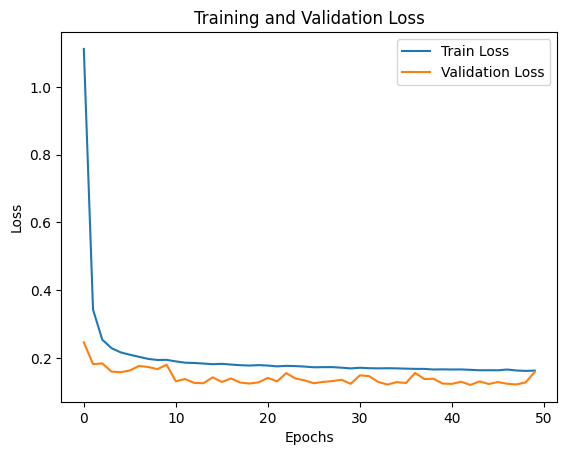

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
RMSE: 542.130878972785
R^2: 0.8731460594558329


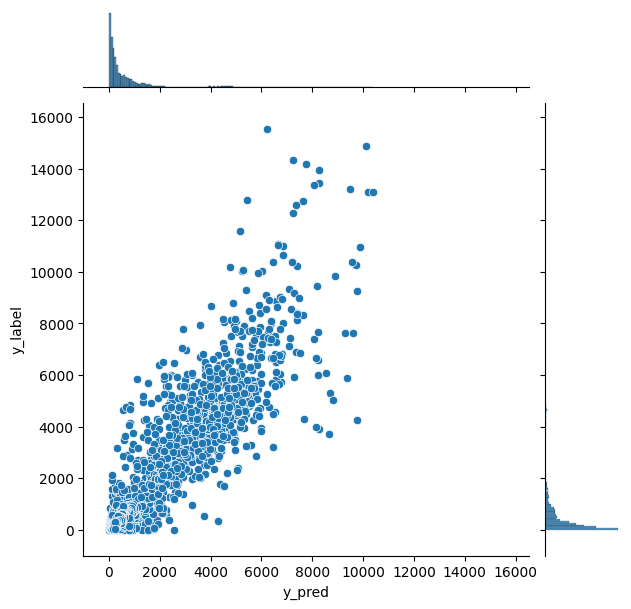

In [15]:
model_ANN = load_model('models_Q2\\ANN_minus1.keras')


y_pred = model_ANN.predict(X_test)
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_minus1['ANN'] = rmse
r2_results_minus1['ANN'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred.reshape(y_test.shape[0]), y_test)


## LSTM

In [71]:
seq_features = ['lag_7', 'lag_8', 'lag_9', 'lag_14', 'lag_21', 'lag_28']
seq_features

['lag_7', 'lag_8', 'lag_9', 'lag_14', 'lag_21', 'lag_28']

In [72]:
static_features = [col for col in X_train_notmiscol.columns if col not in seq_features]

In [73]:
X_seq_train = X_train_notmiscol[seq_features].values.reshape((len(X_train_notmiscol), len(seq_features), 1))
X_seq_val = X_val_notmiscol[seq_features].values.reshape((len(X_val_notmiscol), len(seq_features), 1))
X_seq_test = X_test_notmiscol[seq_features].values.reshape((len(X_test_notmiscol), len(seq_features), 1))

X_static_train = X_train_notmiscol[static_features].values
X_static_val = X_val_notmiscol[static_features].values
X_static_test = X_test_notmiscol[static_features].values

print("X_seq shape:", X_seq_train.shape)        
print("X_static shape:", X_static_train.shape) 


X_seq shape: (46516, 6, 1)
X_static shape: (46516, 80)


In [74]:
# Sequence
seq_input = Input(shape=(len(seq_features), 1))
masked_input = Masking(mask_value=-1)(seq_input)
x1 = LSTM(16, return_sequences=True)(masked_input)
x1 = LSTM(8)(x1)

# Static
static_input = Input(shape=(len(static_features),))
x2 = Dense(32, activation='tanh')(static_input)
x2 = Dropout(0.2)(x2)
x2 = Dense(16, activation='linear')(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(8, activation='linear')(x2)


# Concatenate
combined = Concatenate()([x1, x2])
xc = Dense(8, activation='relu')(combined)
xc = Dense(4, activation='relu')(xc)
output = Dense(1, activation='relu')(xc)

model = Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer='adam', loss='mse')


checkpoint = ModelCheckpoint(
    filepath='models_Q2/LSTM_minus1.keras',
    monitor='val_loss',                        
    save_best_only=True,                        
    save_weights_only=False,                    
    mode='min',                              
    verbose=0                                  
)

history = model.fit([X_seq_train, X_static_train],
                    y_train,
                    epochs=50, batch_size=32,
                    validation_data=([X_seq_val, X_static_val], y_val),
                    callbacks=[checkpoint],
                    verbose=1,
                    )

Epoch 1/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.3464 - val_loss: 0.2016
Epoch 2/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2415 - val_loss: 0.1458
Epoch 3/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1732 - val_loss: 0.1412
Epoch 4/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1391 - val_loss: 0.1299
Epoch 5/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1323 - val_loss: 0.1151
Epoch 6/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1343 - val_loss: 0.1113
Epoch 7/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1262 - val_loss: 0.1128
Epoch 8/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1286 - val_loss: 0.1310
Epoch 9/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1155 - val_loss: 0.1117
Epoch 10/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1170 - val_loss: 0.1085
Epoch 11/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1162 - val_loss: 0.1100
Epoch 12/50
1454/1454 ━━━━━━━━

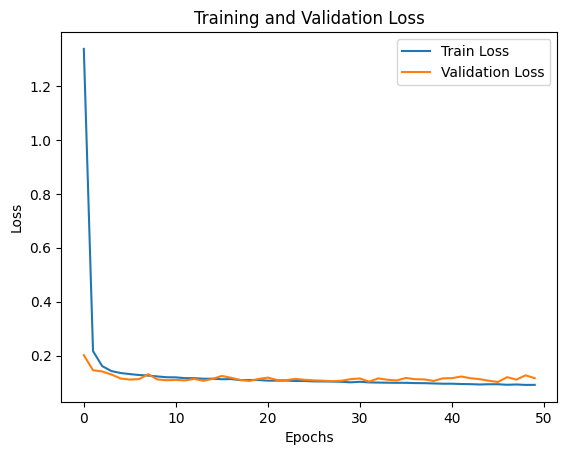

In [75]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 501.5594087909198
R^2: 0.8914223502942995


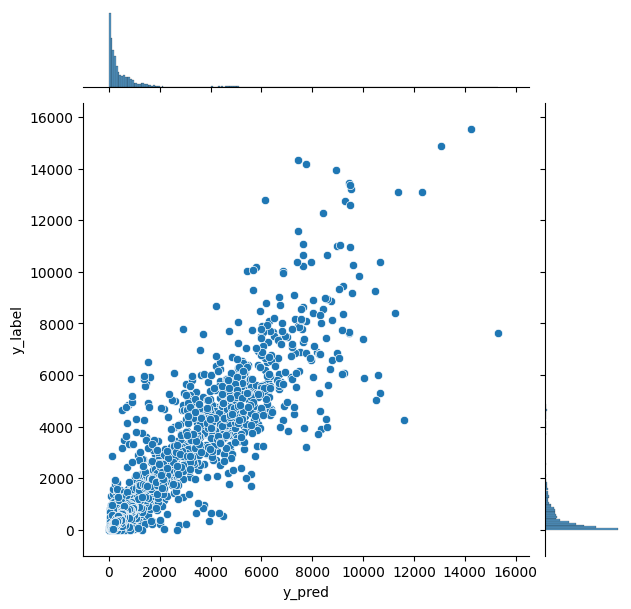

In [76]:
model_LSTM_ANN = load_model('models_Q2/LSTM_minus1.keras')


y_pred = model_LSTM_ANN.predict([X_seq_test, X_static_test])
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_minus1['LSTM'] = rmse
r2_results_minus1['LSTM'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred.reshape(y_test.shape[0]), y_test)


## RNN

In [22]:
# Sequence
seq_input = Input(shape=(len(seq_features), 1))
masked_input = Masking(mask_value=-1)(seq_input)
x1 = SimpleRNN(16, return_sequences=True)(masked_input)
x1 = SimpleRNN(8)(x1)

# Static
static_input = Input(shape=(len(static_features),))
x2 = Dense(32, activation='tanh')(static_input)
x2 = Dropout(0.2)(x2)
x2 = Dense(16, activation='linear')(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(8, activation='linear')(x2)


# Concatenate
combined = Concatenate()([x1, x2])
xc = Dense(8, activation='relu')(combined)
xc = Dense(4, activation='relu')(xc)
output = Dense(1, activation='relu')(xc)

model = Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer='adam', loss='mse')


checkpoint = ModelCheckpoint(
    filepath='models_Q2/RNN_minus1.keras',
    monitor='val_loss',                        
    save_best_only=True,                        
    save_weights_only=False,                    
    mode='min',                              
    verbose=0                                  
)

history = model.fit([X_seq_train, X_static_train],
                    y_train,
                    epochs=50, batch_size=32,
                    validation_data=([X_seq_val, X_static_val], y_val),
                    callbacks=[checkpoint],
                    verbose=1,
                    )

Epoch 1/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.2265 - val_loss: 0.2062
Epoch 2/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2455 - val_loss: 0.1560
Epoch 3/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1608 - val_loss: 0.1241
Epoch 4/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1371 - val_loss: 0.1239
Epoch 5/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1354 - val_loss: 0.1134
Epoch 6/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1282 - val_loss: 0.1121
Epoch 7/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1283 - val_loss: 0.1133
Epoch 8/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1320 - val_loss: 0.1108
Epoch 9/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1279 - val_loss: 0.1346
Epoch 10/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1233 - val_loss: 0.1276
Epoch 11/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1250 - val_loss: 0.1136
Epoch 12/50
1454/1454 ━━━━━━━━

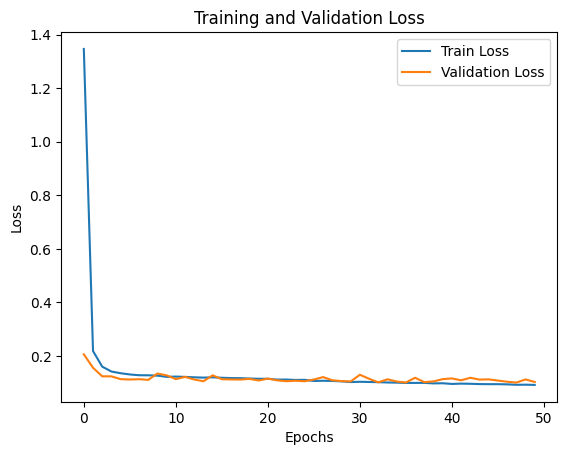

In [23]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 506.35086142354015
R^2: 0.8893379326406978


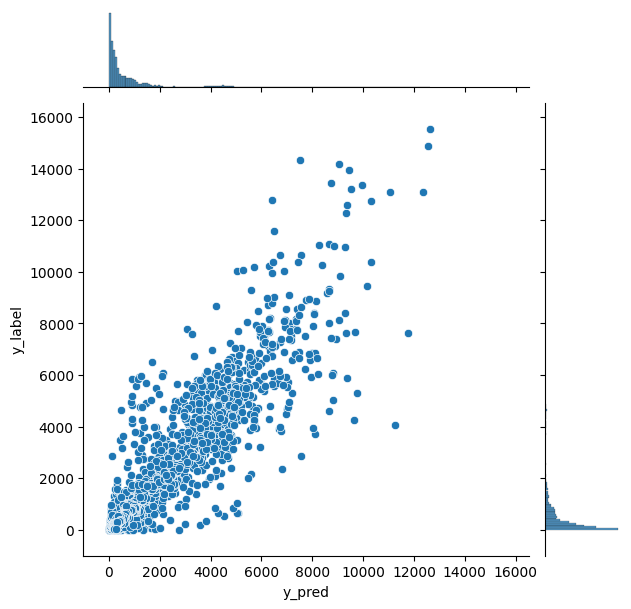

In [24]:
model_RNN_ANN = load_model('models_Q2/RNN_minus1.keras')


y_pred = model_RNN_ANN.predict([X_seq_test, X_static_test])
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_minus1['RNN'] = rmse
r2_results_minus1['RNN'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred.reshape(y_test.shape[0]), y_test)


# Models with mean Imputation for Missing Lag Values

In [25]:
X_train = pd.read_csv('data\Q2\\fill_mean\X_train.csv')
X_val = pd.read_csv('data\Q2\\fill_mean\X_val.csv')
X_test = pd.read_csv('data\Q2\\fill_mean\X_test.csv')
y_train = pd.read_csv('data\Q2\\fill_mean\y_train.csv').values.ravel()
y_val = pd.read_csv('data\Q2\\fill_mean\y_val.csv').values.ravel()
y_test = pd.read_csv('data\Q2\\fill_mean\y_test.csv').values.ravel()
y_test = np.round(np.expm1(y_test))

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(46461, 86) (8173, 86) (9568, 86)
(46461,) (8173,) (9568,)


## KNN

In [26]:
model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': np.arange(70), 
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2],
    }
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])
train_indices = np.arange(len(X_train))
val_indices = np.arange(len(X_train), len(X_train) + len(X_val))
cv_split = [(train_indices, val_indices)]
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=4, verbose=3)
grid_search.fit(X_combined, y_combined)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

joblib.dump(best_model, 'models_Q2\KNN_mean.joblib')

Fitting 1 folds for each of 280 candidates, totalling 280 fits
Best parameters: {'metric': 'minkowski', 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}


['models_Q2\\KNN_mean.joblib']

RMSE: 584.8095120146468
R^2: 0.8534732554474707


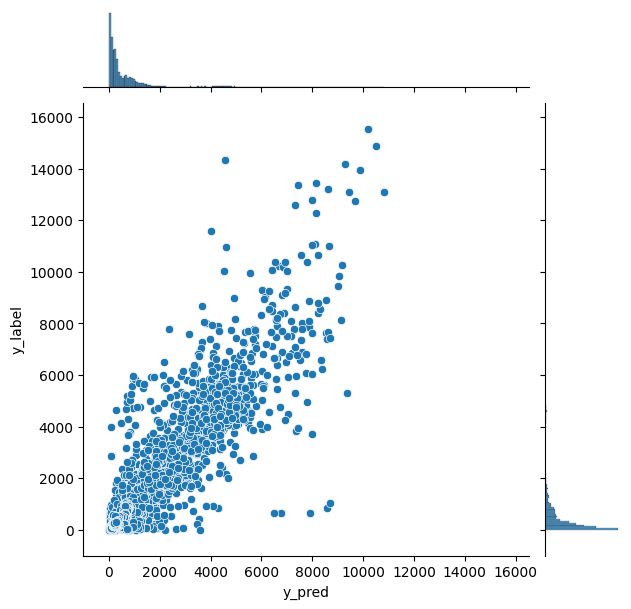

In [27]:
model_KNN = joblib.load('models_Q2\KNN_mean.joblib')


y_pred = model_KNN.predict(X_test)
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_mean['KNN'] = rmse
r2_results_mean['KNN'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred, y_test)

## XGBoost

In [28]:
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', tree_method= 'gpu_hist', missing=-1)
param_grid = {
    'n_estimators': [100, 200, 500, 700, 1000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10, 13],
    'gamma': [0, 0.2]
    }
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])
train_indices = np.arange(len(X_train))
val_indices = np.arange(len(X_train), len(X_train) + len(X_val))
cv_split = [(train_indices, val_indices)]
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=6)
grid_search.fit(X_combined, y_combined)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

joblib.dump(best_model, 'models_Q2\XGBoost_mean.joblib')

Best parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000}


['models_Q2\\XGBoost_mean.joblib']

RMSE: 552.234276624753
R^2: 0.8693423737508456


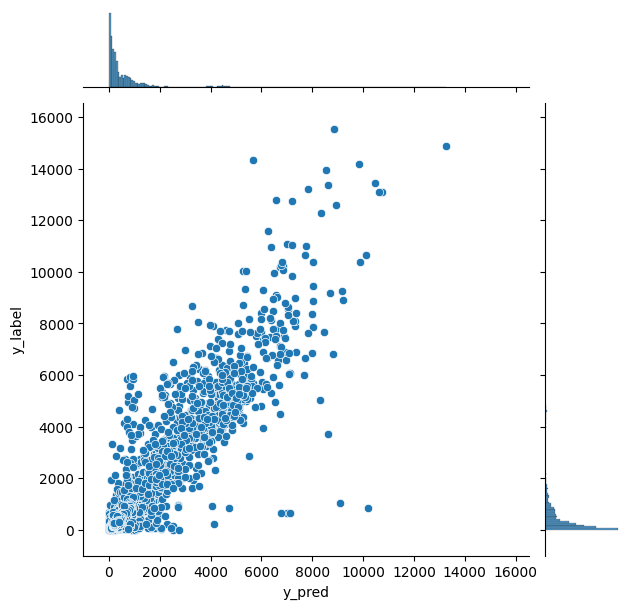

In [29]:
model_XGBoost = joblib.load('models_Q2\XGBoost_mean.joblib')


y_pred = model_XGBoost.predict(X_test)
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_mean['XGBoost'] = rmse
r2_results_mean['XGBoost'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred, y_test)

## ANN

In [30]:
model = Sequential([
    Dense(64, activation='tanh', input_shape=(X_train.shape[1],)), 
    Dropout(0.2),
    Dense(32, activation='linear'),
    Dropout(0.2),
    Dense(16, activation='linear'),
    Dense(8, activation='linear'),
    Dense(4, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

checkpoint = ModelCheckpoint(
    filepath='models_Q2/ANN_mean.keras',
    monitor='val_loss',                        
    save_best_only=True,                        
    save_weights_only=False,                    
    mode='min',                              
    verbose=0                                  
)

history = model.fit(X_train, y_train,
                    epochs=50, batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1,
                    )


Epoch 1/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.4286 - val_loss: 0.2756
Epoch 2/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.5081 - val_loss: 0.2303
Epoch 3/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3150 - val_loss: 0.2071
Epoch 4/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1978 - val_loss: 0.2384
Epoch 5/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1822 - val_loss: 0.1943
Epoch 6/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1777 - val_loss: 0.2185
Epoch 7/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1754 - val_loss: 0.1926
Epoch 8/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1692 - val_loss: 0.1945
Epoch 9/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1640 - val_loss: 0.2356
Epoch 10/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1694 - val_loss: 0.1940
Epoch 11/50
2904/2904 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1641 - val_loss: 0.1937
Epoch 12/50
2904/2904 ━━━━━━━━

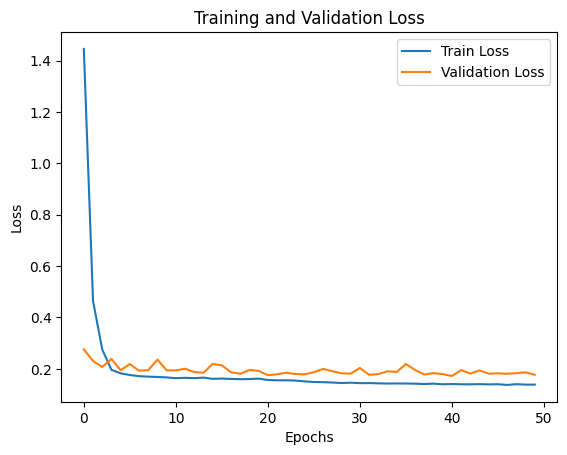

In [31]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
RMSE: 648.5748521472234
R^2: 0.8197778129378399


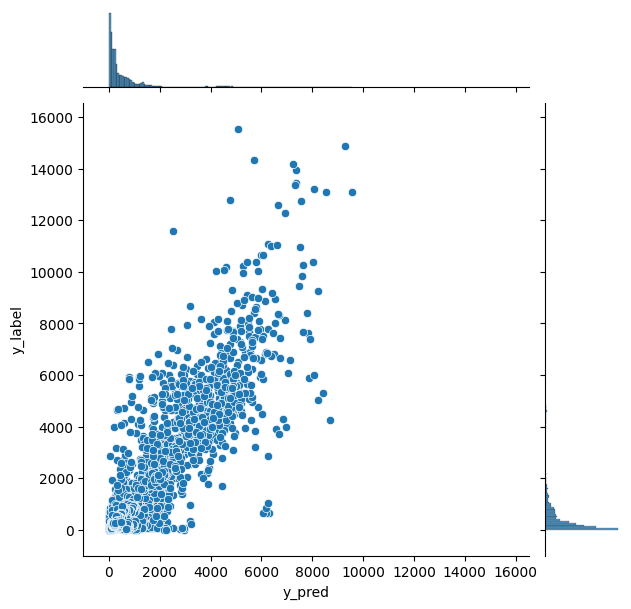

In [32]:
model_ANN = load_model('models_Q2\\ANN_mean.keras')


y_pred = model_ANN.predict(X_test)
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_mean['ANN'] = rmse
r2_results_mean['ANN'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred.reshape(y_test.shape[0]), y_test)


## LSTM

In [33]:
seq_features = ['lag_7', 'lag_8', 'lag_9', 'lag_14', 'lag_21', 'lag_28']
seq_features

['lag_7', 'lag_8', 'lag_9', 'lag_14', 'lag_21', 'lag_28']

In [34]:
static_features = [col for col in X_train.columns if col not in seq_features]

In [35]:
X_seq_train = X_train[seq_features].values.reshape((len(X_train), len(seq_features), 1))
X_seq_val = X_val[seq_features].values.reshape((len(X_val), len(seq_features), 1))
X_seq_test = X_test[seq_features].values.reshape((len(X_test), len(seq_features), 1))

X_static_train = X_train[static_features].values
X_static_val = X_val[static_features].values
X_static_test = X_test[static_features].values

print("X_seq shape:", X_seq_train.shape)        
print("X_static shape:", X_static_train.shape) 


X_seq shape: (46461, 6, 1)
X_static shape: (46461, 80)


In [36]:
# Sequence
seq_input = Input(shape=(len(seq_features), 1))
x1 = LSTM(16, return_sequences=True)(seq_input)
x1 = LSTM(8)(x1)

# Static
static_input = Input(shape=(len(static_features),))
x2 = Dense(32, activation='tanh')(static_input)
x2 = Dropout(0.2)(x2)
x2 = Dense(16, activation='linear')(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(8, activation='linear')(x2)


# Concatenate
combined = Concatenate()([x1, x2])
xc = Dense(8, activation='relu')(combined)
xc = Dense(4, activation='relu')(xc)
output = Dense(1, activation='relu')(xc)

model = Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer='adam', loss='mse')


checkpoint = ModelCheckpoint(
    filepath='models_Q2/LSTM_mean.keras',
    monitor='val_loss',                        
    save_best_only=True,                        
    save_weights_only=False,                    
    mode='min',                              
    verbose=0                                  
)

history = model.fit([X_seq_train, X_static_train],
                    y_train,
                    epochs=50, batch_size=32,
                    validation_data=([X_seq_val, X_static_val], y_val),
                    callbacks=[checkpoint],
                    verbose=1,
                    )

Epoch 1/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 8.7844 - val_loss: 0.2537
Epoch 2/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1601 - val_loss: 0.2269
Epoch 3/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1303 - val_loss: 0.2067
Epoch 4/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1287 - val_loss: 0.2085
Epoch 5/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1235 - val_loss: 0.1953
Epoch 6/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1177 - val_loss: 0.1860
Epoch 7/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1165 - val_loss: 0.1791
Epoch 8/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1160 - val_loss: 0.1643
Epoch 9/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1088 - val_loss: 0.1624
Epoch 10/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1023 - val_loss: 0.1572
Epoch 11/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1085 - val_loss: 0.1594
Epoch 12/50
1452/1452 ━━━━━━━━

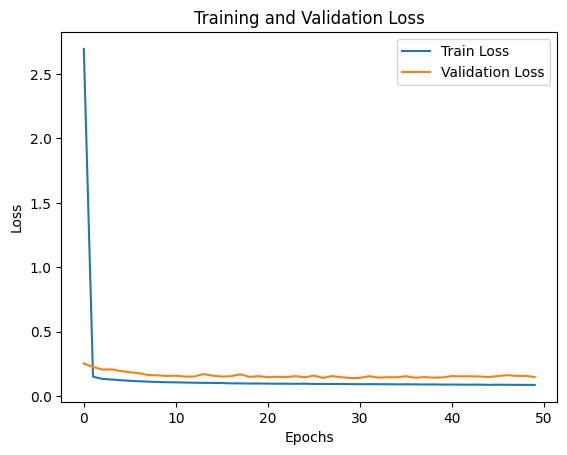

In [37]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RMSE: 594.8547486838888
R^2: 0.8483962615596716


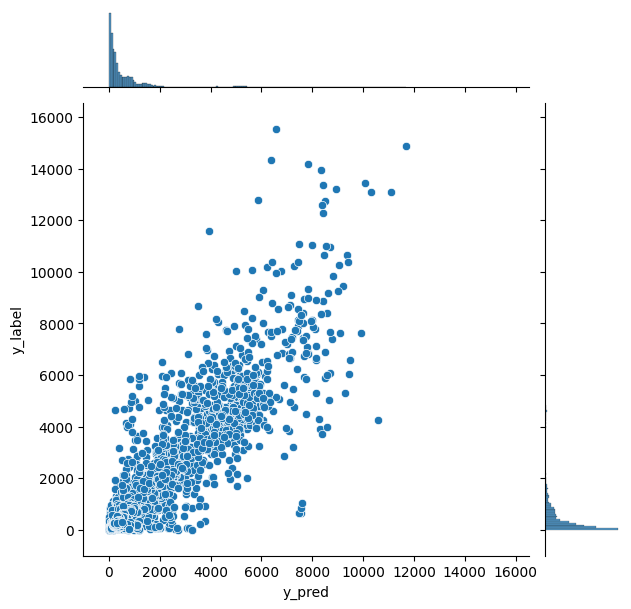

In [38]:
model_LSTM_ANN = load_model('models_Q2/LSTM_mean.keras')


y_pred = model_LSTM_ANN.predict([X_seq_test, X_static_test])
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_mean['LSTM'] = rmse
r2_results_mean['LSTM'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred.reshape(y_test.shape[0]), y_test)


## RNN

In [39]:
# Sequence
seq_input = Input(shape=(len(seq_features), 1))
x1 = SimpleRNN(16, return_sequences=True)(seq_input)
x1 = SimpleRNN(8)(x1)

# Static
static_input = Input(shape=(len(static_features),))
x2 = Dense(32, activation='tanh')(static_input)
x2 = Dropout(0.2)(x2)
x2 = Dense(16, activation='linear')(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(8, activation='linear')(x2)


# Concatenate
combined = Concatenate()([x1, x2])
xc = Dense(8, activation='relu')(combined)
xc = Dense(4, activation='relu')(xc)
output = Dense(1, activation='relu')(xc)

model = Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer='adam', loss='mse')


checkpoint = ModelCheckpoint(
    filepath='models_Q2/RNN_mean.keras',
    monitor='val_loss',                        
    save_best_only=True,                        
    save_weights_only=False,                    
    mode='min',                              
    verbose=0                                  
)

history = model.fit([X_seq_train, X_static_train],
                    y_train,
                    epochs=50, batch_size=32,
                    validation_data=([X_seq_val, X_static_val], y_val),
                    callbacks=[checkpoint],
                    verbose=1,
                    )

Epoch 1/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.5293 - val_loss: 0.2943
Epoch 2/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2171 - val_loss: 0.2489
Epoch 3/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1564 - val_loss: 0.2510
Epoch 4/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1418 - val_loss: 0.1828
Epoch 5/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1225 - val_loss: 0.1700
Epoch 6/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1157 - val_loss: 0.1648
Epoch 7/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1196 - val_loss: 0.1588
Epoch 8/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1113 - val_loss: 0.1690
Epoch 9/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1060 - val_loss: 0.1635
Epoch 10/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1122 - val_loss: 0.1566
Epoch 11/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1030 - val_loss: 0.1647
Epoch 12/50
1452/1452 ━━━━━━━━

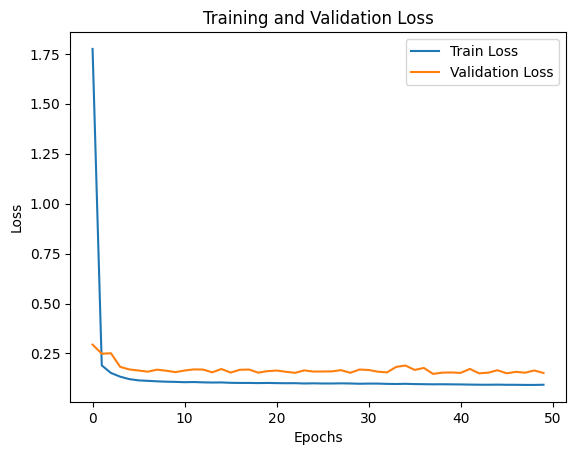

In [40]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RMSE: 582.3635656855259
R^2: 0.8546963787201899


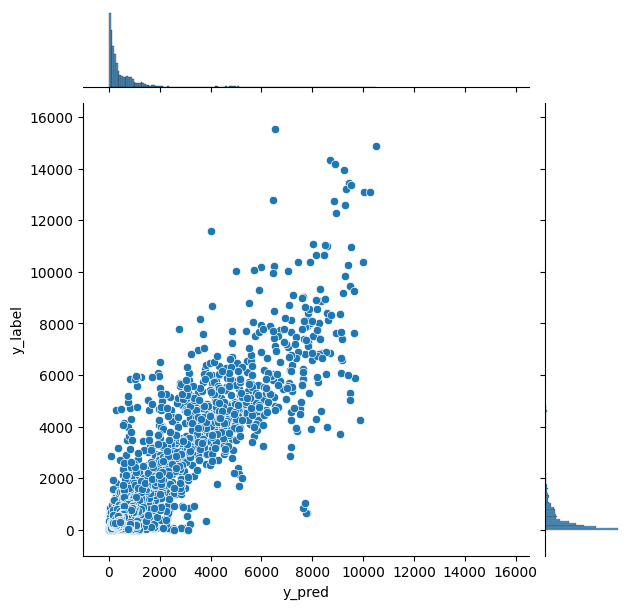

In [41]:
model_RNN_ANN = load_model('models_Q2/RNN_mean.keras')


y_pred = model_RNN_ANN.predict([X_seq_test, X_static_test])
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_mean['RNN'] = rmse
r2_results_mean['RNN'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred.reshape(y_test.shape[0]), y_test)


# Models with knn Imputation for Missing Lag Values

In [7]:
X_train = pd.read_csv('data\Q2\\fill_knn\X_train.csv')
X_val = pd.read_csv('data\Q2\\fill_knn\X_val.csv')
X_test = pd.read_csv('data\Q2\\fill_knn\X_test.csv')
y_train = pd.read_csv('data\Q2\\fill_knn\y_train.csv').values.ravel()
y_val = pd.read_csv('data\Q2\\fill_knn\y_val.csv').values.ravel()
y_test = pd.read_csv('data\Q2\\fill_knn\y_test.csv').values.ravel()
y_test = np.round(np.expm1(y_test))

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(46516, 86) (4175, 86) (3613, 86)
(46516,) (4175,) (3613,)


## KNN

In [43]:
model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': np.arange(70), 
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2],
    }
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])
train_indices = np.arange(len(X_train))
val_indices = np.arange(len(X_train), len(X_train) + len(X_val))
cv_split = [(train_indices, val_indices)]
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=4, verbose=3)
grid_search.fit(X_combined, y_combined)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

joblib.dump(best_model, 'models_Q2\KNN_knn.joblib')

Fitting 1 folds for each of 280 candidates, totalling 280 fits
Best parameters: {'metric': 'minkowski', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}


['models_Q2\\KNN_knn.joblib']

RMSE: 182.11749780241422
R^2: 0.9655304350537318


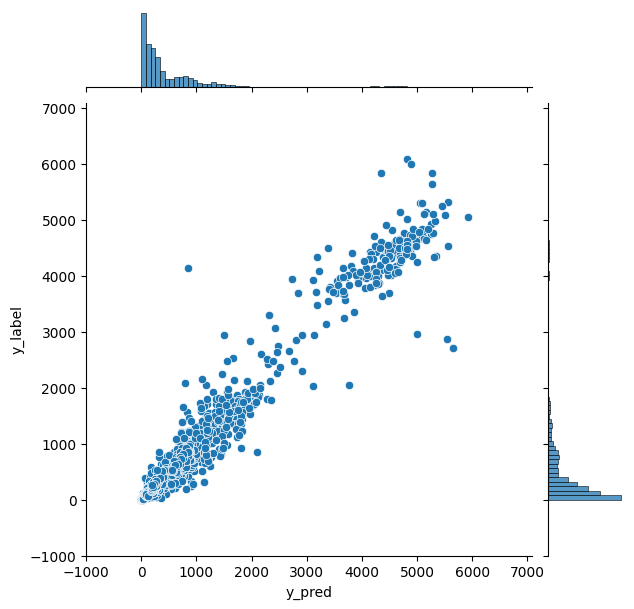

In [44]:
model_KNN = joblib.load('models_Q2\KNN_knn.joblib')


y_pred = model_KNN.predict(X_test)
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_knn['KNN'] = rmse
r2_results_knn['KNN'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred, y_test)

## XGBoost

In [45]:
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', tree_method= 'gpu_hist', missing=-1)
param_grid = {
    'n_estimators': [100, 200, 500, 700, 1000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10, 13],
    'gamma': [0, 0.2]
    }
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])
train_indices = np.arange(len(X_train))
val_indices = np.arange(len(X_train), len(X_train) + len(X_val))
cv_split = [(train_indices, val_indices)]
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=6)
grid_search.fit(X_combined, y_combined)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

joblib.dump(best_model, 'models_Q2\XGBoost_knn.joblib')

Best parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}


['models_Q2\\XGBoost_knn.joblib']

RMSE: 155.28437614834885
R^2: 0.9749396013146469


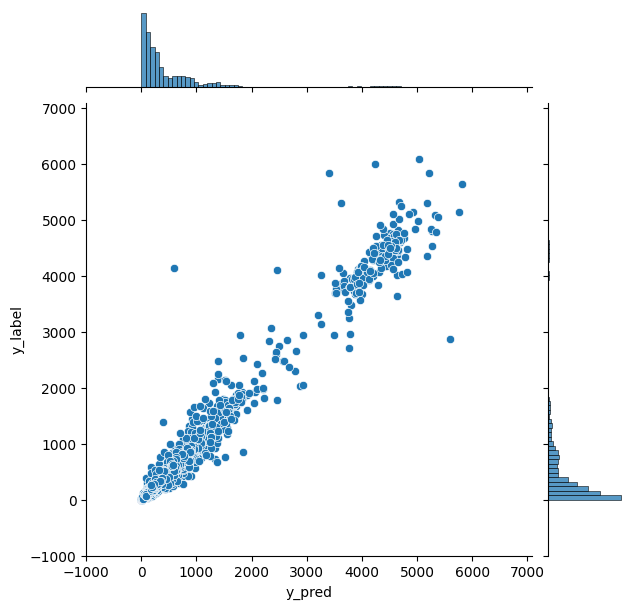

In [46]:
model_XGBoost = joblib.load('models_Q2\XGBoost_knn.joblib')


y_pred = model_XGBoost.predict(X_test)
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_knn['XGBoost'] = rmse
r2_results_knn['XGBoost'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred, y_test)

## ANN

In [47]:
model = Sequential([
    Dense(64, activation='tanh', input_shape=(X_train.shape[1],)), 
    Dropout(0.2),
    Dense(32, activation='linear'),
    Dropout(0.2),
    Dense(16, activation='linear'),
    Dense(8, activation='linear'),
    Dense(4, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

checkpoint = ModelCheckpoint(
    filepath='models_Q2/ANN_knn.keras',
    monitor='val_loss',                        
    save_best_only=True,                        
    save_weights_only=False,                    
    mode='min',                              
    verbose=0                                  
)

history = model.fit(X_train, y_train,
                    epochs=50, batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint],
                    verbose=1,
                    )


Epoch 1/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.9707 - val_loss: 0.1565
Epoch 2/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3007 - val_loss: 0.1139
Epoch 3/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1774 - val_loss: 0.1603
Epoch 4/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1579 - val_loss: 0.1199
Epoch 5/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1508 - val_loss: 0.1249
Epoch 6/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1428 - val_loss: 0.1088
Epoch 7/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1406 - val_loss: 0.1139
Epoch 8/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1322 - val_loss: 0.1017
Epoch 9/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1383 - val_loss: 0.1120
Epoch 10/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1315 - val_loss: 0.1031
Epoch 11/50
2908/2908 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1301 - val_loss: 0.0960
Epoch 12/50
2908/2908 ━━━━━━━━

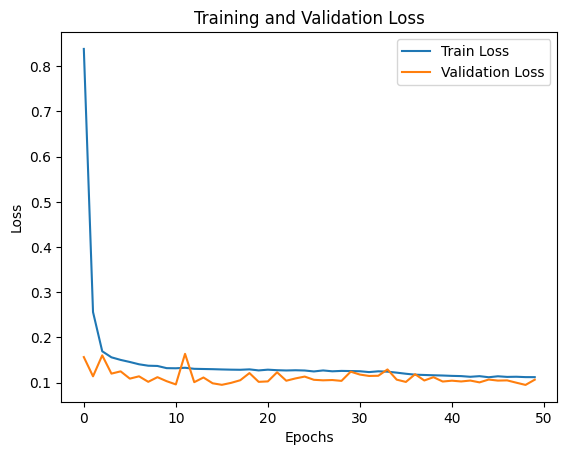

In [48]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
RMSE: 250.1035584018545
R^2: 0.9349911932985312


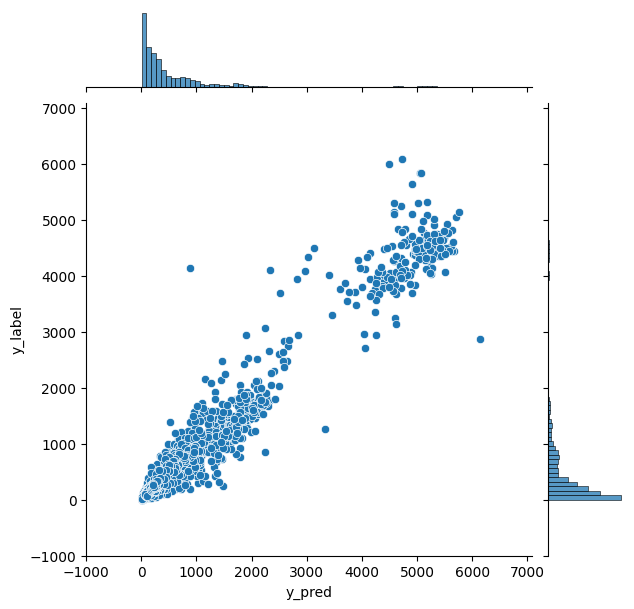

In [49]:
model_ANN = load_model('models_Q2\\ANN_knn.keras')


y_pred = model_ANN.predict(X_test)
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_knn['ANN'] = rmse
r2_results_knn['ANN'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred.reshape(y_test.shape[0]), y_test)


## LSTM

In [9]:
seq_features = ['lag_7', 'lag_8', 'lag_9', 'lag_14', 'lag_21', 'lag_28']
seq_features

['lag_7', 'lag_8', 'lag_9', 'lag_14', 'lag_21', 'lag_28']

In [10]:
static_features = [col for col in X_train.columns if col not in seq_features]

In [12]:
X_seq_train = X_train[seq_features].values.reshape((len(X_train), len(seq_features), 1))
X_seq_val = X_val[seq_features].values.reshape((len(X_val), len(seq_features), 1))
X_seq_test = X_test[seq_features].values.reshape((len(X_test), len(seq_features), 1))

X_static_train = X_train[static_features].values
X_static_val = X_val[static_features].values
X_static_test = X_test[static_features].values

print("X_seq shape:", X_seq_train.shape)        
print("X_static shape:", X_static_train.shape) 


X_seq shape: (46516, 6, 1)
X_static shape: (46516, 80)


In [53]:
# Sequence
seq_input = Input(shape=(len(seq_features), 1))
x1 = LSTM(16, return_sequences=True)(seq_input)
x1 = LSTM(8)(x1)

# Static
static_input = Input(shape=(len(static_features),))
x2 = Dense(32, activation='tanh')(static_input)
x2 = Dropout(0.2)(x2)
x2 = Dense(16, activation='linear')(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(8, activation='linear')(x2)


# Concatenate
combined = Concatenate()([x1, x2])
xc = Dense(8, activation='relu')(combined)
xc = Dense(4, activation='relu')(xc)
output = Dense(1, activation='relu')(xc)

model = Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer='adam', loss='mse')


checkpoint = ModelCheckpoint(
    filepath='models_Q2/LSTM_knn.keras',
    monitor='val_loss',                        
    save_best_only=True,                        
    save_weights_only=False,                    
    mode='min',                              
    verbose=0                                  
)

history = model.fit([X_seq_train, X_static_train],
                    y_train,
                    epochs=50, batch_size=32,
                    validation_data=([X_seq_val, X_static_val], y_val),
                    callbacks=[checkpoint],
                    verbose=1,
                    )

Epoch 1/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.1561 - val_loss: 0.1269
Epoch 2/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1162 - val_loss: 0.1112
Epoch 3/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1088 - val_loss: 0.1220
Epoch 4/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1012 - val_loss: 0.1053
Epoch 5/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0998 - val_loss: 0.0964
Epoch 6/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0882 - val_loss: 0.0949
Epoch 7/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0863 - val_loss: 0.0947
Epoch 8/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0903 - val_loss: 0.0823
Epoch 9/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0879 - val_loss: 0.0850
Epoch 10/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0804 - val_loss: 0.0783
Epoch 11/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0844 - val_loss: 0.0845
Epoch 12/50
1454/1454 ━━━━━━━━

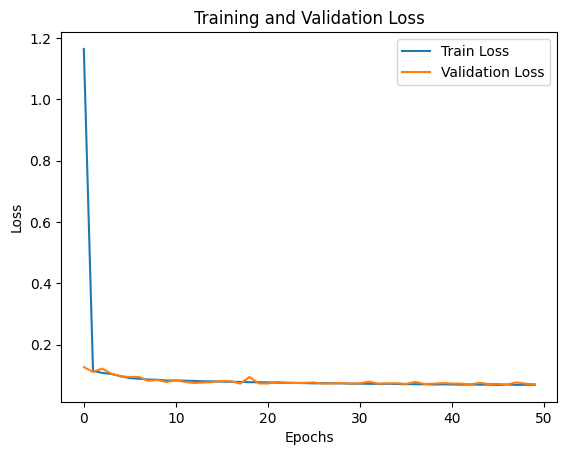

In [54]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 169.05225961858008
R^2: 0.9702987715084849


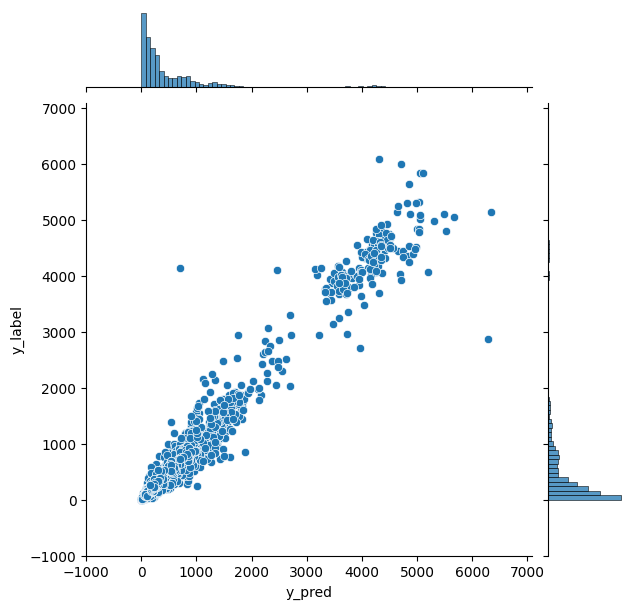

In [55]:
model_LSTM_ANN = load_model('models_Q2/LSTM_knn.keras')


y_pred = model_LSTM_ANN.predict([X_seq_test, X_static_test])
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_knn['LSTM'] = rmse
r2_results_knn['LSTM'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred.reshape(y_test.shape[0]), y_test)


## RNN

In [13]:
# Sequence
seq_input = Input(shape=(len(seq_features), 1))
x1 = SimpleRNN(16, return_sequences=True)(seq_input)
x1 = SimpleRNN(8)(x1)

# Static
static_input = Input(shape=(len(static_features),))
x2 = Dense(32, activation='tanh')(static_input)
x2 = Dropout(0.2)(x2)
x2 = Dense(16, activation='linear')(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(8, activation='linear')(x2)


# Concatenate
combined = Concatenate()([x1, x2])
xc = Dense(8, activation='relu')(combined)
xc = Dense(4, activation='relu')(xc)
output = Dense(1, activation='relu')(xc)

model = Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer='adam', loss='mse')


checkpoint = ModelCheckpoint(
    filepath='models_Q2/RNN_knn.keras',
    monitor='val_loss',                        
    save_best_only=True,                        
    save_weights_only=False,                    
    mode='min',                              
    verbose=0                                  
)

history = model.fit([X_seq_train, X_static_train],
                    y_train,
                    epochs=50, batch_size=32,
                    validation_data=([X_seq_val, X_static_val], y_val),
                    callbacks=[checkpoint],
                    verbose=1,
                    )

Epoch 1/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3.8456 - val_loss: 0.1484
Epoch 2/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1350 - val_loss: 0.1150
Epoch 3/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1172 - val_loss: 0.1181
Epoch 4/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1024 - val_loss: 0.1070
Epoch 5/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0996 - val_loss: 0.0915
Epoch 6/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0953 - val_loss: 0.0880
Epoch 7/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0920 - val_loss: 0.0948
Epoch 8/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0911 - val_loss: 0.1042
Epoch 9/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0920 - val_loss: 0.0919
Epoch 10/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0865 - val_loss: 0.0862
Epoch 11/50
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0866 - val_loss: 0.0958
Epoch 12/50
1454/1454 ━━━━━━━━

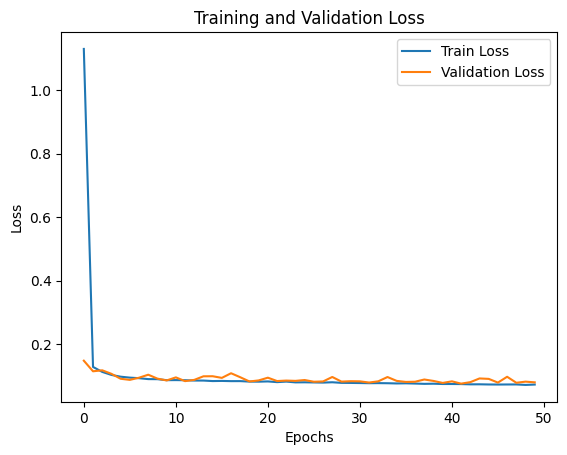

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 175.28649436439662
R^2: 0.9680677615565818


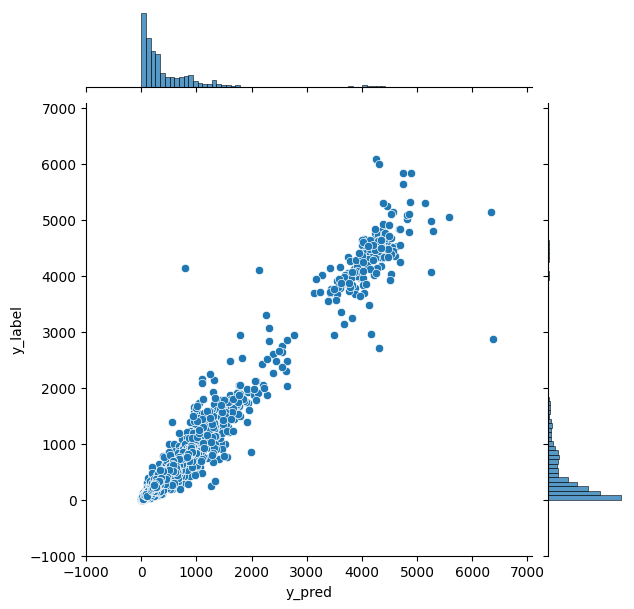

In [15]:
model_RNN_ANN = load_model('models_Q2/RNN_knn.keras')


y_pred = model_RNN_ANN.predict([X_seq_test, X_static_test])
y_pred = np.ceil(np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse_results_knn['RNN'] = rmse
r2_results_knn['RNN'] = r2

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

sns_jointplot(y_pred.reshape(y_test.shape[0]), y_test)


# Compare models

In this section, the results of the models have been analyzed and discussed, which corresponds to the final chart.

In [85]:

rmse_results = pd.DataFrame({
    'minus1': rmse_results_minus1,
    'mean': rmse_results_mean,
    'knn': rmse_results_knn,
}).reset_index().rename(columns={'index': 'model'})


r2_results = pd.DataFrame({
    'minus1': r2_results_minus1,
    'mean': r2_results_mean,
    'knn': r2_results_knn,
}).reset_index().rename(columns={'index': 'model'})


In [ ]:
# rmse_results.to_csv('data/Q2/Summary/rmse_results.csv', index=False)
# r2_results.to_csv('data/Q2/Summary/r2_results.csv', index=False)

In [ ]:
# rmse_results = pd.read_csv('data/Q2/Summary/rmse_results.csv')
# r2_results = pd.read_csv('data/Q2/Summary/r2_results.csv')

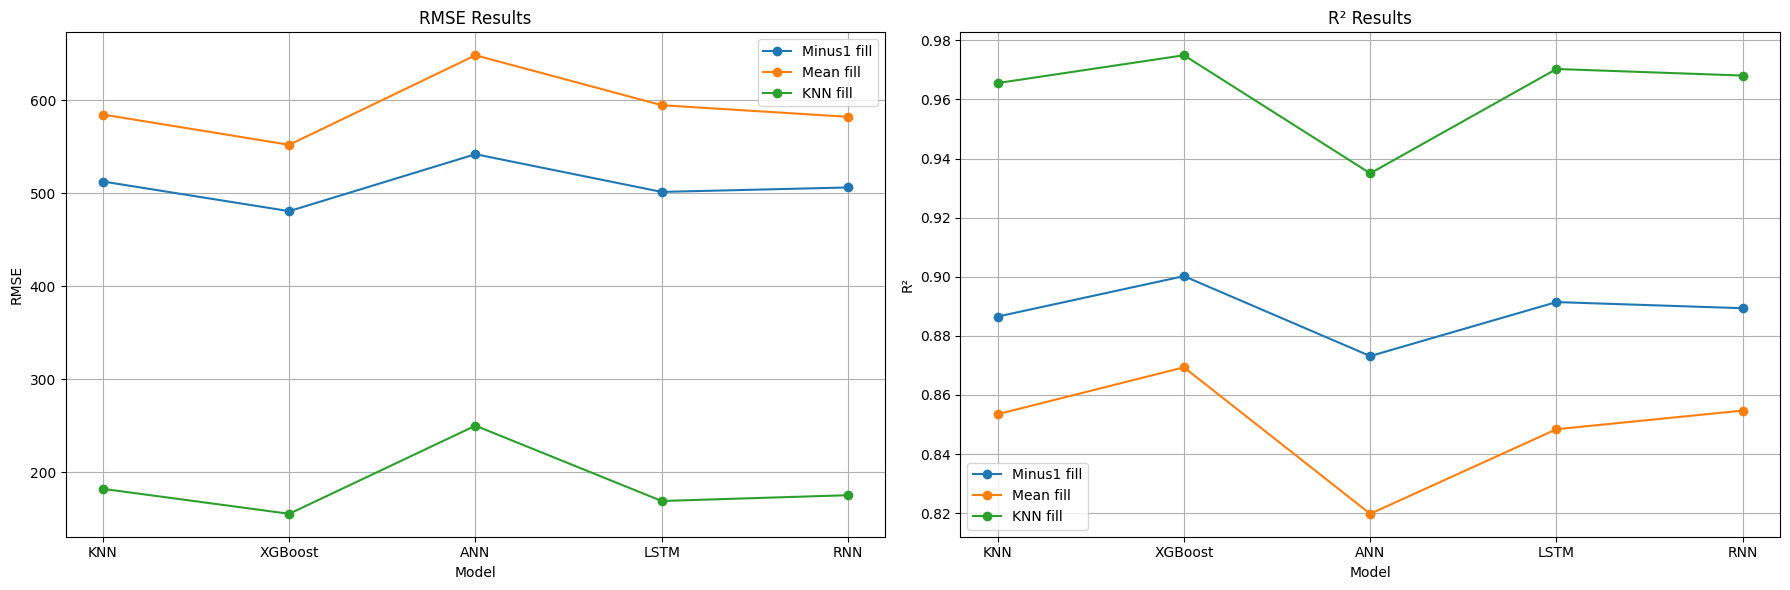

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6)) 

# پلات اول: RMSE
axs[0].plot(rmse_results['model'], rmse_results['minus1'], label='Minus1 fill', marker='o')
axs[0].plot(rmse_results['model'], rmse_results['mean'], label='Mean fill', marker='o')
axs[0].plot(rmse_results['model'], rmse_results['knn'], label='KNN fill', marker='o')
axs[0].set_title('RMSE Results')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('RMSE')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(r2_results['model'], r2_results['minus1'], label='Minus1 fill', marker='o')
axs[1].plot(r2_results['model'], r2_results['mean'], label='Mean fill', marker='o')
axs[1].plot(r2_results['model'], r2_results['knn'], label='KNN fill', marker='o')
axs[1].set_title('R² Results')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('R²')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


 ## **Final Evaluation and Best Model Selection**

For RMSE, the lower the value, the less error the model has.  
For R², the higher the value, the more accurate the model is.

As seen in the charts, the best null value imputation method is **KNN Impute**, as it has consistently produced the best results across all models.  
The best models overall are **XGBoost** and **LSTM**, as they have outperformed the other models under all imputation methods.

The best result is achieved with the following configuration:  
**XGBoost model with KNN Imputation**  
- **RMSE**: 155.28  
- **R²**: 0.9749
